## Determine which population each population-specific trancript is actually population specific to

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [88]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [89]:
min_samples = 2
min_cpm = 0.1
min_tau = 0.8
tau_df = pd.read_csv(f'241023_{min_cpm}_{min_samples}tau.tsv', sep='\t')
tau_df['tau_pop_spec_t'] = tau_df.tau>=min_tau
tau_df_back = tau_df.copy(deep=True)

In [123]:
# get median expression per population
# because this is what the value is computed based on 
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'sample'}, axis=1, inplace=True)
df = df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
df = df.groupby('population').median().reset_index()
# df = df.groupby('population').mean().reset_index()
df.set_index('population', inplace=True)
df.index.name = ''
df = df.transpose()

max_vals = df.max(axis=1)
max_pops = df.idxmax(axis=1)
max_count = (df == max_vals[:, None]).sum(axis=1)

df_copy = df.copy(deep=True)
df_copy[df.eq(max_vals, axis=0)] = float('NaN')
second_max_value = df_copy.max(axis=1)
second_max_column = df_copy.idxmax(axis=1)


df['max_val'] = max_vals
df['max_pop'] = max_pops
df['max_count'] = max_count
df['2_max_val'] = second_max_value
df['2_max_pop'] = second_max_column
df['max_diffs'] = df['max_val']-df['2_max_val']

# remove all with >1 max count
n = len(df.loc[(df.max_count>1)&(df.max_count!=8)].index)
if n > 0: 
    print(f'Warning: found {n} transcripts with duplicate median exp. values across pops')
df = df.loc[df.max_count==1]



df.reset_index(inplace=True)
df.rename({'index':'tid'}, axis=1, inplace=True)
df.head()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,tid,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI,max_val,max_pop,max_count,2_max_val,2_max_pop,max_diffs
0,transcript_6675,0.299724,0.172414,0.357418,0.550844,0.385320,0.706408,0.651034,0.435400,0.706408,MPC,1,0.651034,PEL,0.055374
1,transcript_6676,0.982259,0.540054,0.309999,0.456469,0.431042,0.569546,0.532116,0.697418,0.982259,AJI,1,0.697418,YRI,0.284841
2,transcript_6684,0.433248,0.441766,0.460381,0.688555,0.366190,0.639539,0.600679,0.388386,0.688555,ITU,1,0.639539,MPC,0.049016
3,transcript_6687,0.034472,0.000000,0.027777,0.000000,0.000000,0.059861,0.051411,0.000000,0.059861,MPC,1,0.051411,PEL,0.008450
4,transcript_11363,0.430140,0.709061,0.596585,0.322114,0.196753,0.432933,0.289803,0.470983,0.709061,CEU,1,0.596585,HAC,0.112476


## limted just to pop-spec expressed transcripts

In [125]:
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')

In [126]:
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['max_pop', 'tid']].groupby('max_pop').nunique().reset_index()
temp.head()

,max_pop,tid
0,AJI,2024
1,CEU,1797
2,HAC,2164
3,ITU,1446
4,LWK,1371


[Text(0.5, 0, ''), Text(0, 0.5, '# population-specific transcripts')]

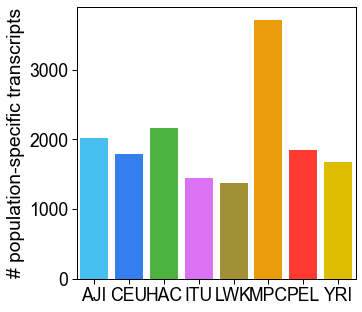

In [127]:
# number of pop-spec transcirpts / pop
ax = sns.barplot(temp, x='max_pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = '# population-specific transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

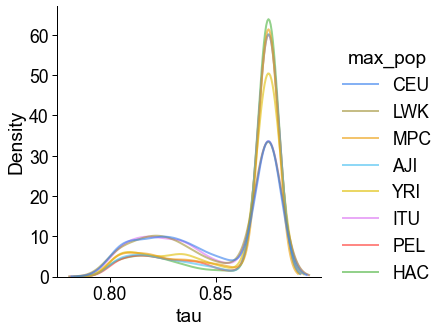

In [94]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)

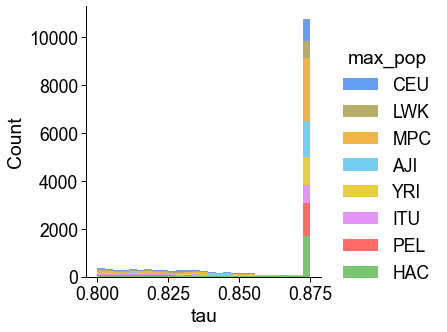

In [95]:
sns.displot(tau_df, kind='hist', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            multiple='stack', linewidth=False)

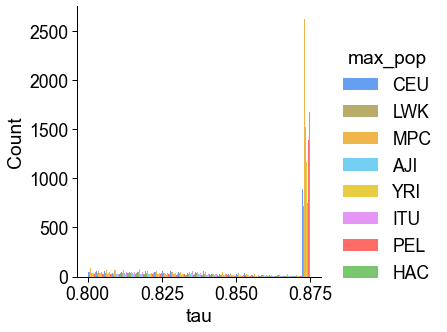

In [96]:
sns.displot(tau_df, kind='hist', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            multiple='dodge', linewidth=False)

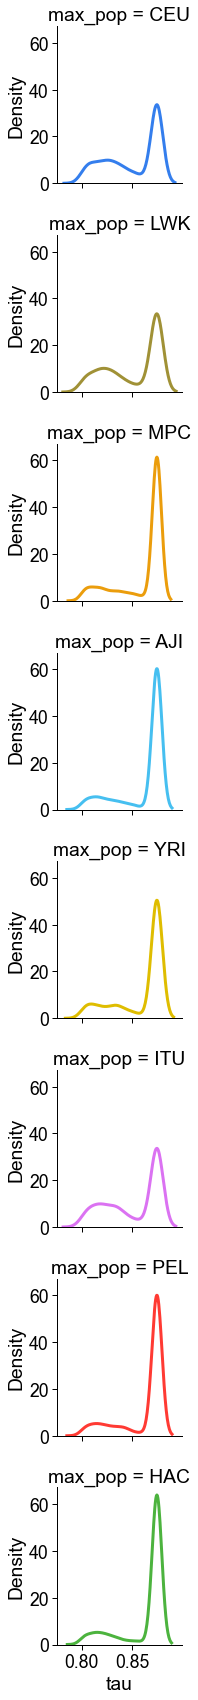

In [97]:
init_plot_settings('square')
g = sns.FacetGrid(tau_df, row='max_pop')
g.map_dataframe(sns.kdeplot, x='tau',
                hue='max_pop', palette=c_dict,
                linewidth=3)

## any transcript

In [128]:
## any transcript that is most median most highly-expressed in one pop or another
tau_df = tau_df_back.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')

[Text(0.5, 0, ''), Text(0, 0.5, '# population-specific transcripts')]

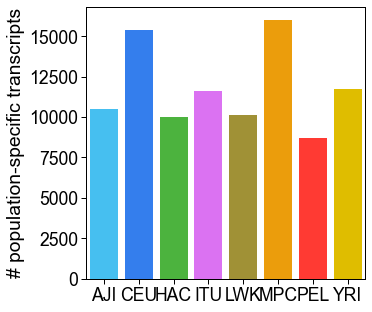

In [129]:
# number of highest-expresseed transcirpts / pop
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['max_pop', 'tid']].groupby('max_pop').nunique().reset_index()
temp.head()
ax = sns.barplot(temp, x='max_pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = '# population-specific transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

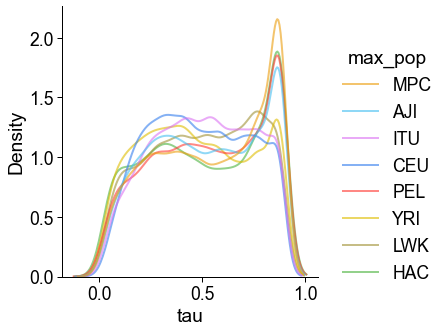

In [130]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)

In [104]:
tau_df.head()

,tid,tau,tau_pop_spec_t,max_val,max_pop
0,transcript_6675,0.324285,False,0.706408,MPC
1,transcript_6676,0.355661,False,0.982259,AJI
2,transcript_6684,0.228488,False,0.688555,ITU
3,transcript_6687,0.635436,False,0.059861,MPC
4,transcript_11363,0.342149,False,0.709061,CEU


## what if we just care about transcripts that are expressed at all in each pop?

In [148]:
# get median expression per population
# because this is what the value is computed based on 
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'sample'}, axis=1, inplace=True)
df = df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
df = df.groupby('population').median().reset_index()
# df = df.groupby('population').mean().reset_index()
df.set_index('population', inplace=True)
df.index.name = ''
df = df.transpose()


# expressed = above min cpm
df = df>=min_cpm

# get only expresesd transcript + population pairs
df = df.melt(ignore_index=False, value_name='expressed', var_name='pop')
df = df.loc[df.expressed==True]
df.reset_index(inplace=True)
df.rename({'index':'tid'}, axis=1, inplace=True)

In [149]:
# merge w/ tau df
tau_df = tau_df_back.merge(df, how='inner', on='tid')

In [150]:
tau_df.head()

,tid,tau,tau_pop_spec_t,pop,expressed
0,transcript_6675,0.324285,False,AJI,True
1,transcript_6675,0.324285,False,CEU,True
2,transcript_6675,0.324285,False,HAC,True
3,transcript_6675,0.324285,False,ITU,True
4,transcript_6675,0.324285,False,LWK,True


[Text(0.5, 0, ''),
 Text(0, 0.5, '# population-expressed\n(med. CPM>=0.1 transcripts')]

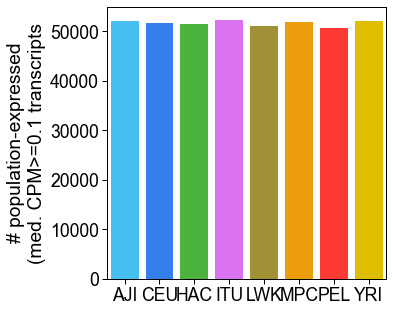

In [153]:
# number of highest-expresseed transcirpts / pop
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['pop', 'tid']].groupby('pop').nunique().reset_index()
temp.head()
ax = sns.barplot(temp, x='pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = f'# population-expressed\n(med. CPM>={min_cpm} transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

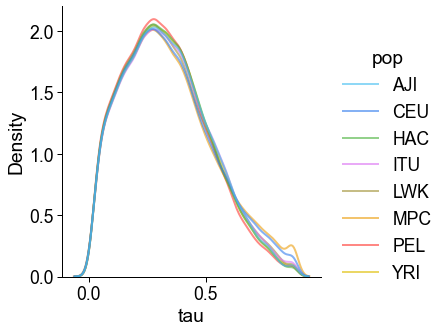

In [154]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)